In [1]:
import numpy as np
import pandas as pd
from functools import partial
from keras import models,layers
from keras.models import Sequential
from keras.layers import Dense, PReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Column names to read the csv file
linkCols = ['linkPVID', 'refNodeID', 'nrefNodeID', 'length', 'functionalClass', 'directionOfTravel', 'speedCategory', 
            'fromRefSpeedLimit', 'toRefSpeedLimit', 'fromRefNumLanes', 'toRefNumLanes', 'multiDigitized', 'urban', 
            'timeZone', 'shapeInfo', 'curvatureInfo', 'slopeInfo']
MatchCols = ['sampleID', 'dateTime', 'sourceCode', 'latitude', 'longitude', 'altitude', 'speed', 'heading', 
             'linkPVID', 'direction', 'distFromRef', 'distFromLink']

In [3]:
# Readind the csv files
link = pd.read_csv(('Partition6467LinkData.csv'), ',', header=None, names=linkCols)
df_matched_points  = pd.read_csv(('Partition6467MatchedPoints.csv'), ',', header=None, names=MatchCols)

In [5]:
# Dropping the rows with no slope info
link = link[link["slopeInfo"].notna()]

In [6]:
# Creating a dataframe which contains the average slope of the link using slopeInfo column
df_avg_slope = link[['linkPVID']].copy()
# Distinguishing slopes  finding average slope of a link
link_slope = link['slopeInfo']
link_slope = link_slope.str.split('|').tolist()
avg_slope = []
for i in range(len(link_slope)):
  arr = link_slope[i]
  avg = 0
  for j in range(len(arr)):
    avg += float(arr[j].split("/")[1])
  avg_slope.append(avg / len(arr))
avg_slope = np.array(avg_slope)
# Add the column to the Dataframe
df_avg_slope['avg_slope'] = avg_slope

In [7]:
# Populating X and Y to train the data
p_index = 0
X = []
Y = []
PVID = []
# Iterating through every sample point and adding the change in altitude and speed, and the distance to the X array used to train the model
for i,sampleID in enumerate (df_matched_points['sampleID'].unique()):
  if i %100 == 0:
    print(i)
  time = 0
  prev_alt = df_matched_points['altitude'][p_index]
  prev_speed = df_matched_points['speed'][p_index]
  while (p_index < len(df_matched_points) and (df_matched_points['sampleID'][p_index] == sampleID)):
      # Since the rows with no slope info has been removed from link df, make sure that the algorithm does not run a row with no slope info. Could be optimized
      if df_matched_points['linkPVID'][p_index] in link.values:
        x = []
        alt_dif = df_matched_points['altitude'][p_index] - prev_alt
        prev_alt = df_matched_points['altitude'][p_index]
        speed_dif = df_matched_points['speed'][p_index] - prev_speed
        prev_speed = df_matched_points['speed'][p_index]
        distance = prev_speed * time
        time = 5 #The time interval between each probe data in seconds
        # Adding these as features to X
        x.append(alt_dif)
        x.append(speed_dif)
        x.append(distance)
        x.append(float(link['length'][link['linkPVID'] == df_matched_points['linkPVID'][p_index]]))
        X.append(x)
        # Adding Y, the average slope
        Y.append(float(df_avg_slope['avg_slope'][df_avg_slope['linkPVID'] == df_matched_points['linkPVID'][p_index]]))
        PVID.append(df_matched_points['linkPVID'][p_index])
      p_index += 1
X = np.array(X)
Y = np.array(Y)
PVID = np.array(PVID)

0


In [8]:
# Normalizing the data
X = (X - X.mean(axis=0)) / X.std(axis=0)
# Splitting the data in training and testing set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X.shape

(322, 4)

In [9]:
# Building the model
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(16, activation = 'relu', input_shape=(4,)))
  model.add(layers.Dense(32, activation = 'relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

In [10]:
# Training the data
model = build_model()
history = model.fit(
    x_train,
    y_train,
    epochs = 1000)

Epoch 1/1000
9/9 [==============================] - 3s 2ms/step - loss: 2.2528 - mae: 1.1059
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 2.1543 - mae: 1.0463
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 2.3486 - mae: 1.1241
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.1407 - mae: 1.0612
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.0634 - mae: 1.0207
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 2.0087 - mae: 1.0158
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 1.9376 - mae: 0.9881
Epoch 8/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.8018 - mae: 0.9550
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.7907 - mae: 0.9494
Epoch 10/1000
9/9 [==============================] - 0s 3ms/step - loss: 1.8873 - mae: 0.9876
Epoch 11/1000
9/9 [==============================] - 0s 2ms/step - lo

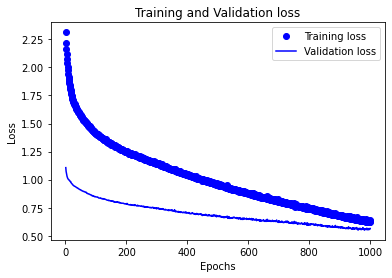

<Figure size 432x288 with 0 Axes>

In [11]:
# PLotting to check if the model is overfitting
loss = history.history["loss"]
val_loss = history.history['mae']
epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label="Training loss")
plt.plot(epochs, val_loss,"b",label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.clf()

In [12]:
# Evaluating on test model
results = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 1.3465 - mae: 0.8900


In [13]:
# Populating the predicted slope colum
result = pd.DataFrame()
result["PVID"] = PVID
result["True_Slope"] = Y
result["Predicted_Slope"] = model.predict(X)

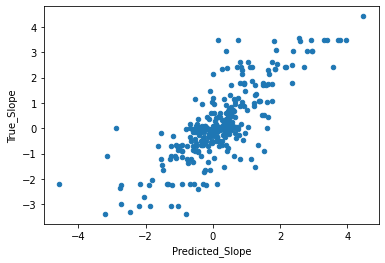

In [14]:
# Visualizing the data. Ideal plot looks like a straight line y = x
result.plot(x="Predicted_Slope", y="True_Slope", kind="scatter")

In [15]:
# Keeping only one row per PVID
p_index = 0
arr = []
for i,PVID in enumerate (result['PVID'].unique()):
  count = 0
  pvid_arr = []
  slope_avg = 0
  while (p_index < len(result) and (result['PVID'][p_index] == PVID)):
    pvid = result['PVID'][p_index]
    True_slope = result['True_Slope'][p_index]
    slope_avg += result["Predicted_Slope"][p_index]
    count += 1
    p_index += 1
  if count != 0:
    pvid_arr.append(pvid)
    pvid_arr.append(True_slope)
    pvid_arr.append((slope_avg/count))
    arr.append(pvid_arr)

result_unique = pd.DataFrame(arr,columns=["PVID","True_Slope","Predicted_Slope"])

In [ ]:
# Saving a csv file
result_unique.to_csv("slope.csv",index=False)